# Tarea 1: MODELOS LINEALES
#### Grupo 1: Avila - Beltramino - Bonet - Cicerchia - Saucedo - Settinimi


## Seteos Preliminares

In [2]:
#Importamos Librerias
import pandas as pd
import numpy as np
import seaborn as sns # Para hacer graficos
import sklearn

from sklearn import datasets
from sklearn.datasets import make_classification

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Lasso, Ridge
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score,roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools

from sklearn.decomposition import PCA

from datetime import datetime, timedelta # Para poder trabajar con formato fecha y hora
from statistics import mode

import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import barh

import warnings
warnings.filterwarnings("ignore")

##  Regresion

### Introducción 

A continuación se propone una tarea de regresión con el dataset “Rossmann Store Sales” este conjunto está disponible en el campus. El objetivo del dataset es predecir las ventas de la cadena de tiendas Rossman. Hay que tener en cuenta que algunas
tiendas se pueden encontrar cerradas, por lo cual no hay actividad. El dataset Rossman_train.csv contiene los datos para realizar las predicciones de las ventas, presentes en la variable “Sales”. El dataset Rossman_store.csv contiene
información extra para la consigna opcional.

#### Lectura y Limpieza de los Datos

##### Lectura de los datos

In [3]:
#rawtrain = pd.read_csv("C:/Users/georg/Desktop/Maestria/DMA/Rossman/Rossman_train.csv")
# RUTA GEORGI "C:/Users/georg/Desktop/Maestria/DMA/Rossman/Rossman_train.csv"
# RUTA MELI "C:/Users/mavila/Desktop/MDGC/DM avanzado/Tareas/Tarea1/Rossman_train.csv"
# RUTA PAU "C:/Users/pbonet/Desktop/DMA/Tarea1/Rossman_originales/Rossman_train.csv"
# test = pd.read_csv("C:/Users/georg/Desktop/Maestria/DMA/Rossman/Rossman_store.csv")
rawtrain = pd.read_csv("C:/Users/pbeltramino/Desktop/MGCD/DMA/Tarea_1/Rossman_train.csv")

In [4]:
# Visualizacion de los primeros valores del Set de Datos 
rawtrain.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# Verificación tamaño del Set de Datos, el tipo de datos y existencia de Nulos
rawtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


No hay N/A en ninguna variable

##### Limpieza

In [6]:
#Guardamos una copia del Set de Datos Original para trabajar 
train = rawtrain.copy()

- Date tiene formato de fecha? No, tiene formato 'Object' 

In [7]:
train['Date'] = pd.to_datetime(train['Date'], format="%Y/%m/%d")
# Corroboremos
train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

- StateHoliday tiene todos los valores correctos? Sabemos que no tiene Nulos. Veamos qué datos tiene

In [8]:
# El value_counts de Pandas permite ver la frecuencia de aparición de un valor, digamos funciona como una tabla de frecuencia.
train["StateHoliday"].value_counts(sort = False)

0    131072
b      6690
c      4100
0    855087
a     20260
Name: StateHoliday, dtype: int64

Hay muchos valores en StateHoliday que, si bien no son nulos, están en 0. Cambiamos los valores para generar una columna numerica. *(Importa para luego hacer la regresion)*

In [9]:
train['StateHoliday']= train['StateHoliday'].map({'a':1, 'b' : 2, 'c': 3, '0':0, 0:0})
# Verifico el tipo de datos y vemos que ya fue convertido a valor numérico "float64" que es la conversión estándar de Pandas 
train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday              int64
SchoolHoliday             int64
dtype: object

### Punto 1
Separar los datos de ventas por tienda y por dia. Esto significa asociar las ventas de cada tienda con igual id en un contenedor. 

In [10]:
# Agrupamos en el Set "bystore" los datos "por dia"
# Entendiendo que "por dia" es por dia de la semana (DayOfWeek) y no por fecha.
bystore = train[["Store", "DayOfWeek", "Sales"]].groupby(['Store','DayOfWeek']).sum()
bystore.head(15)

Sales
Store DayOfWeek         
1     1           662780
      2           627874
      3           601354
      4           552772
      5           609716
      6           662358
      7                0
2     1           775930
      2           719473
      3           770213
      4           630869
      5           602377
      6           384996
      7                0
3     1          1067314

Luego, de forma independiente al procedimiento anterior, obtener el promedio de ventas de cada día.

In [11]:
byday = train[["DayOfWeek", "Sales"]].groupby(['DayOfWeek']).mean()
byday

,Sales
DayOfWeek,
1,7809.044510
2,7005.244467
3,6555.884138
4,6247.575913
5,6723.274305
6,5847.562599
7,204.183189


Realizar un plot de las ventas de los primeros 60 días de la tienda 1. Los ejes deben ser Tiempo vs Ventas. Para ello, primero debemos obtener un data frame con estos filtros: Store == 1 Date >= min(date) Como auxiliar, puedo primero filtrar mi data frame segun store, luego ordenar mi por fecha y obtener las primeras 60 filas

In [12]:
# train.loc['Store'] == 1 esto devuelve booleanos. Todas las posiciones y te va diciendo True si es cierto.
# Luego se lo paso al data set:
step1 = train[train['Store'] == 1]
step2 = step1.sort_values(["Date"], ascending = True) # by default es true
step3 = step2.iloc[0:60] # no hace falta la ,: porque por default toma todas las variables del set
# Chequeamos
# len(step3)
# step3.shape[0]
step4= step3[["Date", "Sales"]]
step4.head()

,Date,Sales
1016095,2013-01-01,0
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997


In [13]:
#Hago una serie con el step4
step5=step4.squeeze() #lo convierte en una time serie
# step5.head()

Text(0, 0.5, 'Ventas')

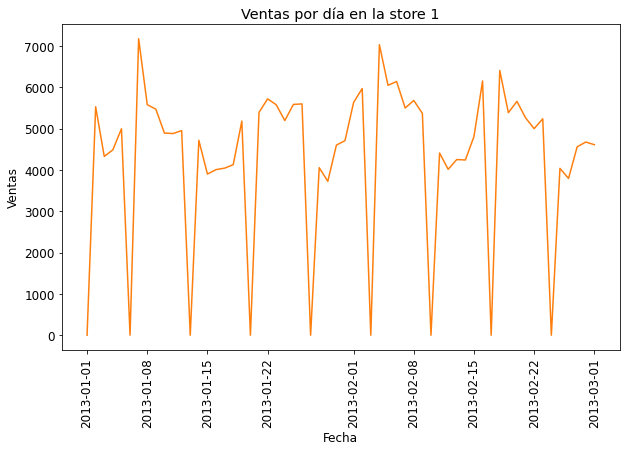

In [14]:
#grafico con matplotlib
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(step5.Date, step5.Sales, color='tab:orange', label='Sales')
plt.xticks(rotation=90)
ax.set_title('Ventas por día en la store 1')
ax.set_xlabel("Fecha")
ax.set_ylabel("Ventas")

Text(0, 0.5, 'Ventas')

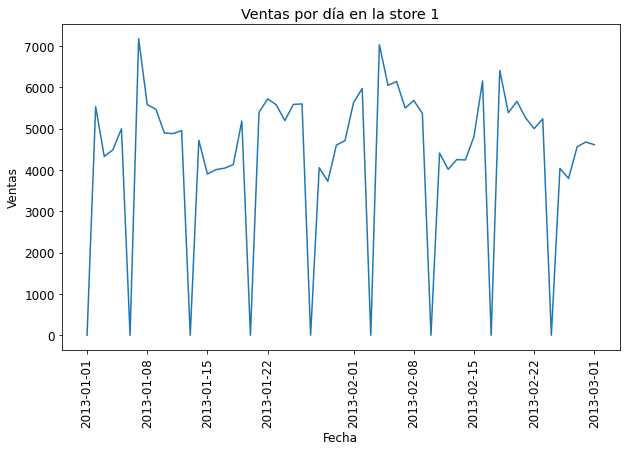

In [15]:
#grafico con seaborn
fig, ax = plt.subplots(figsize=(10, 6))
store1 = sns.lineplot(data=step3, x='Date', y='Sales')
plt.title("Ventas en la Tienda 1")
plt.xticks(rotation=90)
ax.set_title('Ventas por día en la store 1')
ax.set_xlabel("Fecha")
ax.set_ylabel("Ventas")

Pareciera haber un dia en la semana SIN ventas. Veamos cual es:

In [16]:
byDOW = step3[["DayOfWeek", "Sales"]].groupby("DayOfWeek").sum()
byDOW

,Sales
DayOfWeek,
1,43228
2,38169
3,45798
4,42844
5,44814
6,43460
7,0


<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

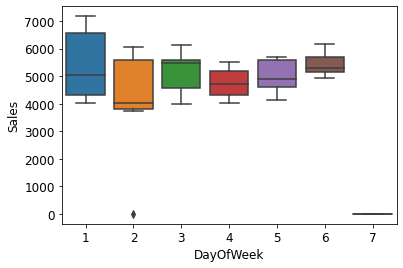

In [17]:
# Tambien se puede ver con un boxplot:
sns.boxplot(data=step3,x="DayOfWeek",y="Sales")

El **domingo**, septimo día, está cerrada la Tienda 1, por eso no se registran ventas.

Realizar un plot del promedio de ventas también de los primeros 60 días. Se calcula el promedio de ventas de todas las tiendas. Los ejes deben ser Tiempo vs Ventas.

In [18]:
# Restrinjo el data frame a los primeros 60 dias
#fechalimite = min(train["Date"]) + timedelta(days=60)
paso1 = train[train['Date'] <= min(train["Date"]) + timedelta(days=60)]
# max(paso1["Date"]) Para asegurar
paso1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
949195,1,6,2013-03-02,5350,678,1,0,0,0
949196,2,6,2013-03-02,2643,353,1,0,0,0
949197,3,6,2013-03-02,5037,638,1,0,0,0
949198,4,6,2013-03-02,10541,1557,1,0,0,0
949199,5,6,2013-03-02,1939,242,1,0,0,0


In [19]:
byday = paso1[["Date", "Sales"]].groupby("Date", as_index=False).mean()
byday.head()

,Date,Sales
0,2013-01-01,87.284560
1,2013-01-02,6233.030493
2,2013-01-03,5693.112108
3,2013-01-04,5954.218834
4,2013-01-05,5337.751570


Text(0, 0.5, 'Promedio de Ventas')

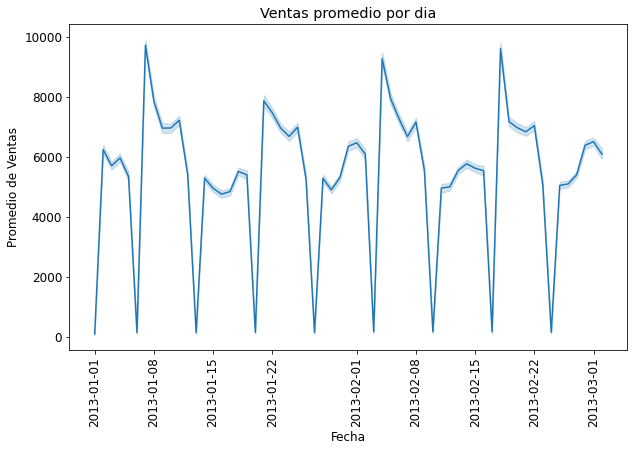

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
avgstore = sns.lineplot(data= paso1, x='Date', y='Sales', estimator= 'mean') # Excelente esto
plt.title("Ventas promedio por dia") 
plt.xticks(rotation=90)
ax.set_xlabel("Fecha")
ax.set_ylabel("Promedio de Ventas")

### Punto 2
Dividir los datos originales en Train y Test. Seleccionar los últimos 10 días para realizar tests sobre el modelo.

In [21]:
#Parto mi data frame en dos:
# Train: todo salvo los ultimos 10 dias
# fecha limite = max(train["Date"]) + timedelta(days=-10)
df_train = train[
    (train["Date"] >= min(train["Date"])) &
    (train['Date'] <= max(train["Date"]) + timedelta(days=-10))
]
iTrain=df_train.index
# print(min(df_train["Date"])) # Para asegurar
# print(max(df_train["Date"])) # Para asegurar
# df_train.head(5)

In [22]:
# Parto mi data frame en dos:
# Test: ultimos 10 dias
# fecha inicial = max(train["Date"]) + timedelta(days=-10)
df_test = train[train["Date"] >= max(train["Date"]) + timedelta(days=-10)]
iTest=df_test.index
# print(min(df_test["Date"])) # Para asegurar
# print(max(df_test["Date"])) # Para asegurar

### Punto 3
Seleccione y entrene un modelo de regresión lineal. Justifique brevemente por que eligio dicho modelo.

In [23]:
df2=train.copy()
#df2.dtypes

#La conviertopara poder escalar
df2["Date"]=pd.to_numeric(train["Date"])
X_data = df2.to_numpy()


st = StandardScaler()
X = st.fit_transform(X_data)

Antes de entrenar el modelo separo de los Sets de Datos *Train* y *Test* la variable a predecir

In [24]:
y= X[:,3]
X=np.delete(X , 3 , axis=1)

X_train =X[iTrain]
X_test=X[iTest]
y_train=y[iTrain]
y_test= y[iTest]

In [25]:
# Selecciono y entreno con Lasso

warnings.filterwarnings("ignore")
shrink = np.arange(0., 1., step=0.05)

scores = np.zeros(shrink.size)
R = []
C = []
t = KFold(n_splits=5, random_state=0, shuffle=True)
betas = np.ndarray(shape=(shrink.size, X.shape[1]))
for ii, s in enumerate(shrink):
  for tr, te in t.split(X_train):
    lin_reg = Lasso(alpha=s)
    lin_reg.fit(X_train[tr], y_train[tr])
    R.append(lin_reg.score(X_train[te], y_train[te]))
    C.append(lin_reg.coef_)
  scores[ii] = np.array(R).mean()
  betas[ii] = np.asarray(C).mean(axis=0)

array([0.8540927 , 0.85105524, 0.84577297, 0.83790823, 0.82733897,
       0.8144693 , 0.80043706, 0.7852801 , 0.7693375 , 0.75234648,
       0.73413981, 0.71460603, 0.69366794, 0.67127042, 0.64737305,
       0.6219455 , 0.59496459, 0.56641229, 0.536601  , 0.50977084])

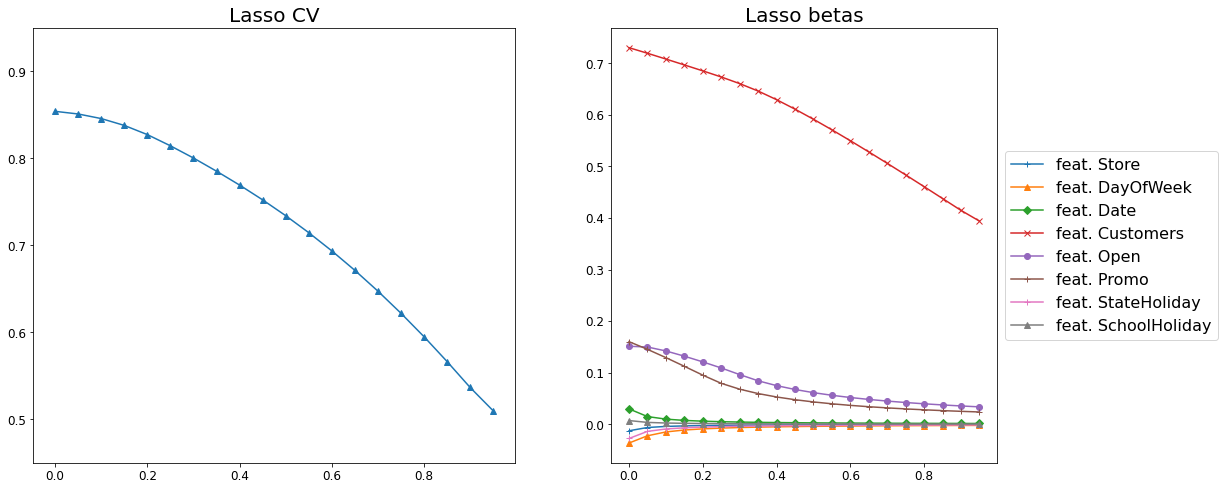

In [26]:
fig = plt.figure(figsize=(19,8))
ax = fig.add_subplot(121)
ax.plot(shrink, scores, marker='^')
ax.set_title('Lasso CV', fontsize=20)
ax.set_ylim([0.45, 0.95])
ax = fig.add_subplot(122)
marks = itertools.cycle(['+', '^', 'D', 'x', 'o'])
m = next(marks)
df11=train.drop('Sales', axis = 1)
for ii,(row, col) in enumerate(zip(betas.T, df11.columns.values)):
  if ii > 0 and ii%6:
    m = next(marks)
  ax.plot(shrink, row, marker=m, label='feat. ' + str(col))
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
ax.set_title('Lasso betas', fontsize=20)
scores

Para lambda = 0 se obtiene el mejor score.

In [27]:
lin_reg = Lasso(alpha=0.00)
lin_reg.fit(X_train, y_train)
y_te_lasso = lin_reg.predict(X_test)

print('Train score: ' + str(lin_reg.score(X_train, y_train)))
print('Test score: ' + str(lin_reg.score(X_test, y_test)))

Train score: 0.8540981768947521
Test score: 0.8037396969213595


In [28]:
# Selecciono y entreno con Ridge

shrink = 10**np.linspace(0., 10., num=20)
#shrink = np.arange(0., 1., step=0.05)
scores = np.zeros(shrink.size)
R = []
C = []
t = KFold(n_splits=5, random_state=0, shuffle=True)
betas = np.ndarray(shape=(shrink.size, X.shape[1]))
for ii, s in enumerate(shrink):
  for tr, te in t.split(X_train):
    lin_reg = Ridge(alpha=s)
    lin_reg.fit(X_train[tr], y_train[tr])
    R.append(lin_reg.score(X_train[te], y_train[te]))
    C.append(lin_reg.coef_)
  scores[ii] = np.array(R).mean()
  betas[ii] = np.asarray(C).mean(axis=0)
scores

array([0.8540927 , 0.8540927 , 0.8540927 , 0.8540927 , 0.8540927 ,
       0.85409267, 0.85409236, 0.85408934, 0.85406039, 0.85380768,
       0.85208685, 0.84438526, 0.82251403, 0.78426095, 0.73913828,
       0.6951021 , 0.65483353, 0.6186293 , 0.58611935, 0.5568273 ])

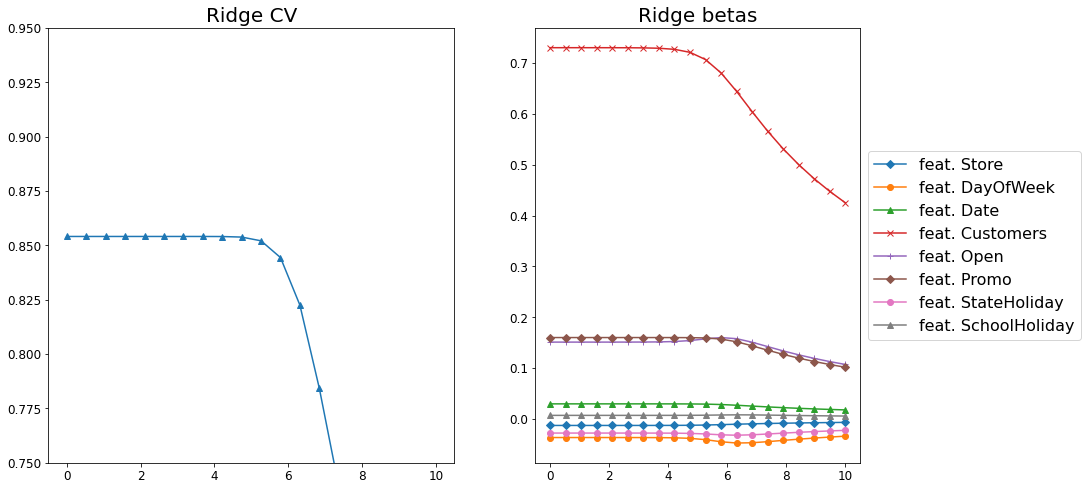

In [29]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.plot(np.log10(shrink), scores, marker='^')
ax.set_title('Ridge CV', fontsize=20)
ax.set_ylim([0.75, 0.95])
ax = fig.add_subplot(122)
marks = itertools.cycle(['+', '^', 'D', 'x', 'o'])
m = next(marks)
for row, col in zip(betas.T, df11.columns.values):
  if ii > 0 and ii%6:
    m = next(marks)
  ax.plot(np.log10(shrink), row, marker=next(marks), label='feat. ' + str(col))
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('Ridge betas', fontsize=20)
# Put a legend to the right of the current axis
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

Con Ridge se obtiene el mismo resultado que con Lasso. El mejor score se obtiene para los parametros de penalizacion = 0.

In [30]:
lin_reg = Ridge(alpha=0)
lin_reg.fit(X_train, y_train)
y_te_ridge = lin_reg.predict(X_test)

print('Train score: ' + str(lin_reg.score(X_train, y_train)))
print('Test score: ' + str(lin_reg.score(X_test, y_test)))

Train score: 0.8540981768947522
Test score: 0.8037396969212738


Logicamente, ambos dan lo mismo, puesto que en ambos modelos se seleccionaron parametros de penalizacion iguales a 0. En definitiva, es una regresion de minimos cuadrados. Esto es válido si el set de datos tiene poca varianza. Se utilizara entonces la salida de y_te_lasso.

In [31]:
df_test.set_index('Date', inplace=True)
df_train.set_index('Date', inplace=True)

# TRAIN
# Con esto obtengo un array de 1*n dimensiones, con la variable a predecir
y_train = df_train["Sales"]
# Y acá solo me queda en el df las variables que explican y
x_train =df_train.drop(['Sales'], axis=1)
#x_train.head()

# TEST
# Con esto obtengo un array de 1*n dimensiones, con la variable a predecir
y_test = df_test['Sales']
# Y acá solo me queda en el df las variables que explican y
x_test =df_test.drop(['Sales'], axis=1)

In [32]:
# define model
model = Lasso(normalize=True) #al utilizar normalize=True evitamos estandarizar el set de datos previamente
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -974.752
Config: {'alpha': 0.04}


In [33]:
# Seleccionamos Lasso entonces con alpha = 0
lin_reg = Lasso(alpha=0.0)
lin_reg.fit(x_train, y_train)
y_prediccion = lin_reg.predict(x_test)

### Punto 4
Considere que la variable open = 0, implica y = 0. Realice nuevamente el punto 3 y compare los resultados. Comente, brevemente e informe los scores del modelo.

In [34]:
# Veamos si hay algun registro donde Open == 0 y Sales != 0
train_sales = train.loc[(train.Open == 0)]
train_sales.loc[(train.Sales != 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


No hay registros. Si hubiese registros, se deberia aplicar esta funcion: train.where(lambda open: open == 0, lambda sales: 0)

In [35]:
#Genero un nuevo subset con los campos open == 1, que es donde voy a entrenar
df3 = train[train['Open'] == 1]

In [36]:
df3['Date'] = pd.to_datetime(df3['Date'], format="%Y/%m/%d")
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          844392 non-null  int64         
 1   DayOfWeek      844392 non-null  int64         
 2   Date           844392 non-null  datetime64[ns]
 3   Sales          844392 non-null  int64         
 4   Customers      844392 non-null  int64         
 5   Open           844392 non-null  int64         
 6   Promo          844392 non-null  int64         
 7   StateHoliday   844392 non-null  int64         
 8   SchoolHoliday  844392 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 64.4 MB


In [37]:
#El nuevo subset tiene 844.392 registros contra los 1.017.209
#Genero nuevos sets de train y test

# fecha limite = max(train["Date"]) + timedelta(days=-10)
df_train2 = df3[
    (df3["Date"] >= min(df3["Date"])) &
    (df3['Date'] < max(df3["Date"]) + timedelta(days=-10))
]
#iTrain=df_train.index

# Parto mi data frame en dos:
# Test: ultimos 10 dias
# fecha inicial = max(train["Date"]) + timedelta(days=-10)
df_test2 = df3[
    (df3["Date"] <= max(df3["Date"])) &
    (df3["Date"] >= max(df3["Date"]) + timedelta(days=-10))]
#iTest=df_test.index
# print(min(df_test["Date"])) # Para asegurar
# print(max(df_test["Date"])) # Para asegura

In [38]:
df_test2.set_index('Date', inplace=True)
df_train2.set_index('Date', inplace=True)

In [39]:
# TRAIN
# Con esto obtengo un array de 1*n dimensiones, con la variable a predecir
y_train2 = df_train2["Sales"]
# Y acá solo me queda en el df las variables que explican y
x_train2 =df_train2.drop(['Sales'], axis=1)
#x_train.head()


# TEST
# Con esto obtengo un array de 1*n dimensiones, con la variable a predecir
y_test2 = df_test2['Sales']
# Y acá solo me queda en el df las variables que explican y
x_test2 =df_test2.drop(['Sales'], axis=1)

In [40]:
# define model
model = Lasso(normalize=True) #al utilizar normalize=True evitamos estandarizar el set de datos previamente
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train2, y_train2)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -1153.027
Config: {'alpha': 0.0}


In [41]:
#El MAE del método seleccionado está calculado sobre los registros de train con la condición Open==1.Ahora bien, 
#si quisieramos calcular el MAE del modelo completo, considerando que Open==0 => y=0, la suma de los errores absolutos
# se mantiene constante, pues el error para Open==0  es cero. De esta forma, ajustando el n de cáculo, se puede obtener un MAE
#comparable con el del punto 3.


In [42]:
N= len(df_train.index) # largo de matriz original de train
N

1006059

In [43]:
n= len(df_train2.index) # largo de matriz reducida de train
n

833230

In [44]:
##Factor de corrección del MAE = n/N
FC=n/N

In [45]:
#Nuevo MAE
MAE= -1153.024*FC
MAE

-954.9481566389246

In [46]:
#Vemos que el error del nuevo modelo es de -954 contra los -979 del primer modelo, mejorando un 3% el resultado

In [47]:
 #train.where(lambda open: open == 0, lambda sales: 0)

### Punto 5
Predicción sobre los datos de test. Genere un plot que contraste las ventas verdaderas contra las ventas predichas por el modelo vs. la fecha. Realice esto con el promedio de ventas por día y para las tiendas 1 y 100

In [48]:
# Preparar df prediccion
df_pred = pd.DataFrame(y_prediccion)
df_pred.set_axis(['sales_prediction'], axis='columns', inplace=True)
df_test.reset_index(inplace=True)
fechas_y_store = df_test[["Date", "DayOfWeek", "Store"]]
df_prediccion = pd.concat([fechas_y_store, df_pred], axis=1)

Promedio de ventas por dia

Text(0, 0.5, 'Promedio de Ventas')

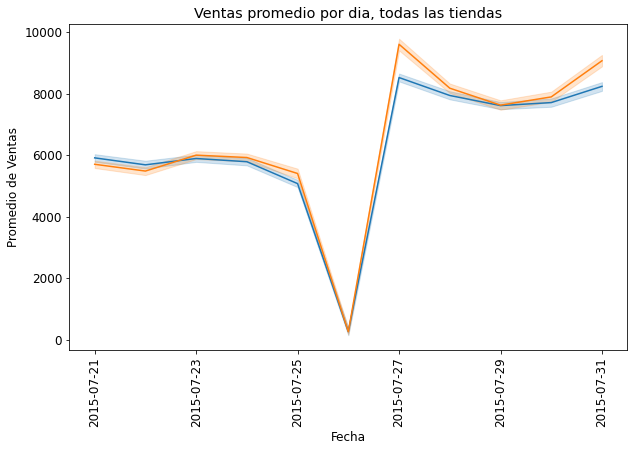

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
avgpred = sns.lineplot(data= df_prediccion, x='Date', y='sales_prediction', estimator= 'mean')
avgtest = sns.lineplot(data= df_test, x='Date', y='Sales', estimator= 'mean')
plt.title("Ventas promedio por dia, todas las tiendas") 
plt.xticks(rotation=90)
ax.set_xlabel("Fecha")
ax.set_ylabel("Promedio de Ventas")

Tienda 1

In [50]:
onlyStore1_pred = df_prediccion[df_prediccion['Store'] == 1]
#byDOW_pred = onlyStore1_pred[["DayOfWeek", "sales_prediction"]].groupby(['DayOfWeek']).mean() # Si usamos sns no hace falta

onlyStore1_test = df_test[df_test['Store'] == 1]
#byDOW_test = onlyStore1[["DayOfWeek", "Sales"]].groupby(['DayOfWeek']).mean() # Si usamos sns no hace falta

Text(0, 0.5, 'Ventas')

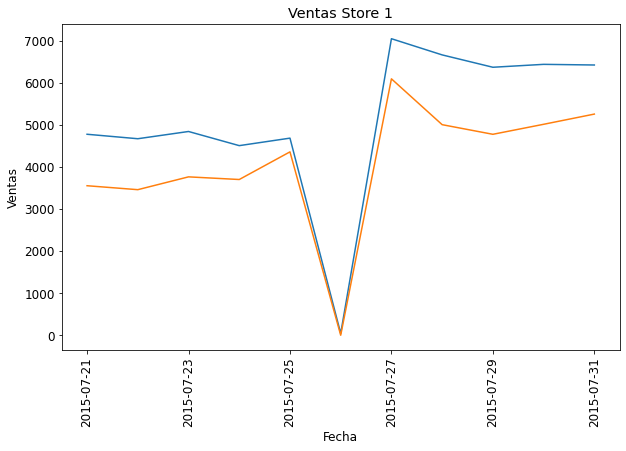

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
avgpred = sns.lineplot(data= onlyStore1_pred, x='Date', y='sales_prediction', estimator= 'mean')
avgtest = sns.lineplot(data= onlyStore1_test, x='Date', y='Sales', estimator= 'mean')
plt.title("Ventas Store 1") 
plt.xticks(rotation=90)
ax.set_xlabel("Fecha")
ax.set_ylabel("Ventas")

Tienda 100

In [52]:
onlyStore100_pred = df_prediccion[df_prediccion['Store'] == 100]
onlyStore100_test = df_test[df_test['Store'] == 100]

Text(0, 0.5, 'Ventas')

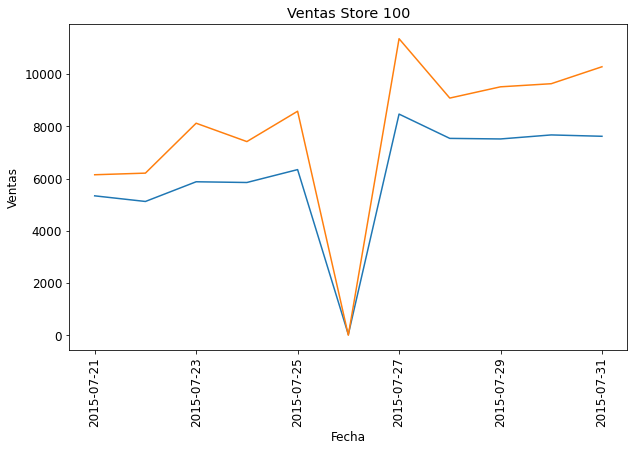

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
avgpred = sns.lineplot(data= onlyStore100_pred, x='Date', y='sales_prediction')
avgtest = sns.lineplot(data= onlyStore100_test, x='Date', y='Sales')
plt.title("Ventas Store 100") 
plt.xticks(rotation=90)
ax.set_xlabel("Fecha")
ax.set_ylabel("Ventas")

### Punto 6 (Opcional)
Utilizar las variables “Assortment” y “StoreType del archivo Rossman_store.csv para separar los datos y construir múltiples modelos de predicción. Por ejemplo Assortment=a y StoreType=a , da lugar a la clase 1 y Assortment=a y StoreType=b da lugar a la clase 2. La idea es considerar ambas variables para generar una clase. Posteriormente se dividen los datos acorde a estas clases y se crean modelos. Como ayuda se da el siguiente dato: se pueden crear 9 modelos en total. Recordar separar datos en train y test según la fecha.

In [58]:
rs = pd.read_csv("C:/Users/pbeltramino/Desktop/MGCD/DMA/Tarea_1/Rossman_store.csv")
#"C:/Users/mavila/Desktop/MDGC/DM avanzado/Tareas/Tarea1/Rossman_store.csv" MELI
# "C:/Users/georg/Desktop/Maestria/DMA/Rossman/Rossman_store.csv" GEORGI
# "C:/Users/pbonet/Desktop/DMA/Tarea1/Rossman_originales/Rossman_store.csv" PAU 
rs.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [59]:
rs.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [60]:
# Por prolijidad convertimos a Assortment y a StoreType en variables categoricas
rs["Assortment"] = rs["Assortment"].astype("category")
rs["StoreType"] = rs["StoreType"].astype("category")
# Corroboramos
# rs.dtypes

In [61]:
# Valores posibles de Assortmen
rs["Assortment"].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [62]:
# Valores posibles de StoreType
rs["StoreType"].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [63]:
# Feature Engineering
# Creamos la variable "class" de la combinación de las variables "Assortment" y "StoreType"
#Esta es una manera, pero queda muy extenso

rs.loc[(rs['Assortment'] == 'a') & (rs["StoreType"] == 'a'), 'class'] = 1
rs.loc[(rs['Assortment'] == 'a') & (rs["StoreType"] == 'b'), 'class'] = 2
rs.loc[(rs['Assortment'] == 'a') & (rs["StoreType"] == 'c'), 'class'] = 3
rs.loc[(rs['Assortment'] == 'a') & (rs["StoreType"] == 'd'), 'class'] = 4
rs.loc[(rs['Assortment'] == 'b') & (rs["StoreType"] == 'a'), 'class'] = 5
rs.loc[(rs['Assortment'] == 'b') & (rs["StoreType"] == 'b'), 'class'] = 6
rs.loc[(rs['Assortment'] == 'b') & (rs["StoreType"] == 'c'), 'class'] = 7
rs.loc[(rs['Assortment'] == 'b') & (rs["StoreType"] == 'd'), 'class'] = 8
rs.loc[(rs['Assortment'] == 'c') & (rs["StoreType"] == 'a'), 'class'] = 9
rs.loc[(rs['Assortment'] == 'c') & (rs["StoreType"] == 'b'), 'class'] = 10
rs.loc[(rs['Assortment'] == 'c') & (rs["StoreType"] == 'c'), 'class'] = 11
rs.loc[(rs['Assortment'] == 'c') & (rs["StoreType"] == 'd'), 'class'] = 12

#Esta puede ser otra manera, cual es mas performante?

#def fclass(row): if (row['Assortment'] == 'a') & (row['StoreType'] == 'a'): val = 1 elif (row['Assortment'] == 'a') & (row['StoreType'] == 'b'): val = 2 elif (row['Assortment'] == 'a') & (row['StoreType'] == 'c'): val = 3
#else: val = 4 ### ETC return val

#rs['class'] = rs.apply(fclass, axis=1)

#Con numpy se puede hacer tambien, pero hay anidar un monton y puede confundir. Ejemplo: df['hasimage'] = np.where(df['photos']!= '[]', True, False)

In [64]:
rs["class"].value_counts(sort = False)

3.0      77
1.0     381
11.0     71
9.0     221
4.0     128
12.0    220
2.0       7
6.0       9
10.0      1
Name: class, dtype: int64

In [65]:
# llevamos la variable class al dataframe train
class_store = rs.loc[:, ['Store', 'class']]
train_class = train.join(class_store.set_index('Store'), on='Store', how = 'left')
train_class.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,class
0,1,5,2015-07-31,5263,555,1,1,0,1,3.0
1,2,5,2015-07-31,6064,625,1,1,0,1,1.0
2,3,5,2015-07-31,8314,821,1,1,0,1,1.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,11.0
4,5,5,2015-07-31,4822,559,1,1,0,1,1.0


In [66]:
# Convierto con 
train_class["class"] = train_class["class"].astype("int")
clases = np.unique(train_class["class"])
clases

array([ 1,  2,  3,  4,  6,  9, 10, 11, 12])

Vemos que quedan solo 9 categorias

In [67]:
#dividimos el dataset en 9 subsets distintos segun las clases
for x in clases:
    globals()["dfclass" + str(x)] = train_class[(train_class["class"] == x)]

In [68]:
#pruebo que me hayan quedado bien
dfclass9.head(3)
dfclass9.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday              int64
SchoolHoliday             int64
class                     int32
dtype: object

In [69]:
# Para todos divido en train y test / pongo fecha como indice / defino los x e y para cada dataset
for x in clases:
    #train
    df = globals()["dfclass" + str(x)]
    globals()["dfclass" + str(x)+"_train"] = df[
    (df["Date"] >= min(df["Date"])) &
    (df["Date"] <= max(df["Date"]) + timedelta(days=-10))
]
    globals()["dfclass" + str(x)+"_train"].set_index('Date', inplace=True)
    df_train_clase = globals()["dfclass" + str(x)+"_train"]
    globals()["dfclass" + str(x)+"_train_y"] = df_train_clase['Sales']
    globals()["dfclass" + str(x)+"_train_x"] = df_train_clase.drop(['Sales'], axis=1)
    
    #test
    globals()["dfclass" + str(x)+"_test"] = df[
    (df["Date"] <= max(df["Date"])) &
    (df["Date"] >= max(df["Date"]) + timedelta(days=-10))
]
    globals()["dfclass" + str(x)+"_test"].set_index('Date', inplace=True)
    df_test_clase = globals()["dfclass" + str(x)+"_test"]
    globals()["dfclass" + str(x)+"_test_y"] = df_test_clase['Sales']
    globals()["dfclass" + str(x)+"_test_x"] = df_test_clase.drop(['Sales'], axis=1)

In [70]:
# Aplicamos modelo
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#para cada dataset de clase buscamos los mejores parametros y aplicamos los 9 modelos de prediccion
for i in clases:
    print('Clase', i)
    # perform the search
    x= globals()["dfclass" + str(i)+"_train_x"]
    y = globals()["dfclass" + str(i)+"_train_y"]
    x_test = globals()["dfclass" + str(i)+"_test_x"]
    y_test = globals()["dfclass" + str(i)+"_test_y"]
    result = search.fit(x,y)
    # reporto los parametros encontrados
    print('MAE: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    # aplico modelo
    lin_reg = Lasso(alpha=results.best_params_['alpha'])
    lin_reg.fit(x, y)
    globals()["y_prediccion_"+ str(i)] = lin_reg.predict(x_test)
    print('Train score: ' + str(lin_reg.score(x, y)))
    print('Test score: ' + str(lin_reg.score(x_test, y_test)))

Clase 1
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.9149795466730625
Test score: 0.8867526581797346
Clase 2
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.9493202968656427
Test score: 0.9494296994440985
Clase 3
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.9181843917567257
Test score: 0.8785143790851482
Clase 4
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.912222578700063
Test score: 0.8826572529357306
Clase 6
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.8888303004839551
Test score: 0.819617802784774
Clase 9
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.9098526424155087
Test score: 0.8829422211311408
Clase 10
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.8265046702230889
Test score: 0.862110386873536
Clase 11
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.9211157241384664
Test score: 0.8905645905176436
Clase 12
MAE: -1153.027
Config: {'alpha': 0.0}
Train score: 0.8923519021687
Test score: 0.838401496216318


## Clasificacion

### Introducción
Una empresa tiene una base de datos sobre recursos humanos relacionada con profesionales de Big Data y Data Science, a los cuales desea contratar. Se desea saber qué candidatos pueden estar interesados en cambiar de trabajo.
   - Los datos no están balanceados.
   - Hay muchas variables categóricas.
   - Hay valores faltantes
Se sugiere no tomar acción sobre el desbalanceo de clases.

### Punto 1
Preparar los datos. Considerar que puede haber variables que no son informativas como podrían ser 'enrollee_id' y 'city'. Explícitamente transformar las variables que lo requieran en categóricas y luego usar codificación onehot utilizando pd.get_dummies. Separar la variable target y normalizar los datos.

#### Lectura y Limpieza de los Datos

##### Lectura de los Datos

In [ ]:
# Load the Drive helper and mount (pablo)
#from google.colab import drive

# This will prompt for authorization. (pablo)
#drive.mount('/content/drive/')

raw_data = pd.read_csv("C:/Users/georg/Desktop/Maestria/DMA/HR_train/aug_train.csv")
#ruta meli "C:/Users/mavila/Desktop/MDGC/DM avanzado/Tareas/Tarea1/aug_train.csv"
#ruta georgi "C:/Users/georg/Desktop/Maestria/DMA/HR_train/aug_train.csv"
#ruta pau "C:/Users/pbonet/Desktop/DMA/Tarea1/aug_train.csv"
#ruta pablo "/content/drive/MyDrive/DM-AVANZADO/datasets/aug_train.csv"

In [ ]:
# Visualizacion de los primeros valores del Set de Datos 
raw_data.head()

In [ ]:
# Visualizacion tipo de datos del Set
raw_data= pd.DataFrame(raw_data)
raw_data.dtypes

#### Limpieza 

##### Conversión de Variables Categóricas

In [ ]:
# Si se quiere chequear qué variables convertir. Ejemplo: major_discipline, experience, company_size, que uno esta en duda, usar:
raw_data["target"].value_counts()
# Ver qué cantidad de valores hay y en base a eso definir si se convierten (converti todo)

In [ ]:
# Convertimos variables a categoricas
var = ["gender",
        "relevent_experience",
        "enrolled_university",
        "education_level",
        "major_discipline",
        "experience",
        "company_size",
        "company_type",
        "last_new_job",
      "target"]
# Vamos con un loop
for i in range(len(var)):
    raw_data[var[i]] = raw_data[var[i]].astype("category")
# Corroboremos
raw_data.dtypes

##### Identificación y Tratamiento de Valores Nulos

In [ ]:
# Para saber si en el df hay Nan:
# raw_data.isnull().values.any()
# Para ver en una columna particular
# raw_data["gender"].isnull().values.any()
# Se puede crear un df donde veamos en qué columnas hay null
raw_data.isnull().any()

In [ ]:
# El tema es que no se puede reemplazar con cualquier valor, se debe reemplazar con un valor que ya esté en la columna.
# Para poder ver todo cn un solo chunk y menos codigo:
# Primero nos quedamos con las variables que tienen valores nulos:
columnas = list(raw_data.columns[raw_data.isnull().any() == True])
# Vamos con un loop
for i in range(len(columnas)):
    print(raw_data[columnas[i]].value_counts())

Asignamos el valor "Desconocido a los NA"

In [ ]:
# Una manera seria agregar en cada valor una categoria

#raw_data["gender"] = raw_data["gender"].cat.add_categories('Desconocido')
#raw_data["gender"].fillna('Desconocido', inplace =True)

# Vamos con un loop
for i in range(len(columnas)):
    raw_data[columnas[i]] = raw_data[columnas[i]].cat.add_categories('Desconocido')
    raw_data[columnas[i]].fillna('Desconocido', inplace =True)
    
# Corroboremos
raw_data.isnull().any()

Ya tenemos el set "raw_data" transformado, sin valores "NA" e identificadas correctamente las variables categóricas. 
Ahora prepararemos el dataframe de trabajo "df" a partir de "raw_data", para ello:
- eliminamos las variables que no aportan información relevante para los objetivos de este análisis.
- separamos la variable "target" del df de trabajo y la almacenamos en df_target.
- convertimos las variables categoricas en numericas como variables "dummies". 

In [ ]:
# Eliminamos variables que no aportan informacion relevante
df = raw_data.drop(['enrollee_id', 'city'], axis=1)

# Separamos la variable "target" del df de trabajo y la almacenamos en df_target
df_target = df["target"]
df = df.drop(["target"], axis=1)

# Convertimos las variables categoricas en numericas como variables "dummies" 
columnas_cat = df.columns[df.dtypes == "category"]

df_cat = pd.get_dummies(df[columnas_cat], drop_first = False, dummy_na = False)

df_cat.head(5)

In [ ]:
#eliminamos las variables categoricas originales y conservamos su reemplazo por variables "dummies"
df.drop(columnas_cat, axis = 1, inplace = True)
df = pd.concat([df, df_cat], axis = 1)

Generamos un data frame escalado "scaled_df" 

In [ ]:
# Generamos un data frame escalado "scaled_df" 
X_data = df.to_numpy()
st = StandardScaler()
X = st.fit_transform(X_data) #array escalado
scaled_df = pd.DataFrame(X, columns=df.columns) #data frame escalado

scaled_df.head(5)

### Punto 2
Visualizar los datos con PCA. Mostrar la relación de varianza explicada de todas las variables y plotear pc1 vs. pc2 y pc1 vs. pc3. Que se puede comentar sobre el gráfico.

#### Análisis PCA

In [ ]:
#Analisis PCA
pc=PCA(n_components= None) # al utilizar "None" calculamos todas las componentes posibles

X_pca = pc.fit_transform(X) #uso el array escalado 

#Porcentaje de varianza explicada por cada componente

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
ax.bar(
    x      = np.arange(pc.n_components_) + 1,
    height = pc.explained_variance_ratio_
)

for x, y in zip(np.arange(len(scaled_df.columns)) + 1, pc.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pc.n_components_) + 1)
ax.set_ylim(0, 0.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [ ]:
#COMENTARIO PAU: este gráfico muestra lo mismo que el de barras para mi. Es necesario?
fig = plt.figure(figsize=(24,8)) 

# varianza explicada
ax = fig.add_subplot(131)
ax.plot(pc.explained_variance_ratio_, marker='^')
ax.set_title('PCA: Ratio de Varianza Explicada', fontsize=20)

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pc.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
ax.plot(
    np.arange(len(scaled_df.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(scaled_df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pc.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
ax.set_ylabel('Por. varianza acumulada');

Del análisis PCA podemos ver que: 
- Para explicar el 80%  de la varianza se necesitan 44 componentes Principales de las 71 variables del Set de Datos en análisis.
- Con 23 componentes Principales puede explicarse el 50% de la varianza.
- Las primeras 3 componentes principales solo logran explicar el 14% de la varianza.

Revisamos las relaciones entre PC1 vs PC2 y PC1 vs PC3

In [ ]:
#Incorporación de la variable "target" para analizar clusterización 
scaled_df_1 = pd.concat([scaled_df, df_target], axis = 1)

#Grafico de PC1 vs PC2 y PC1 vs PC3
fig, ax = plt.subplots(1, 2,  figsize=(24, 8))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=scaled_df_1.target, cmap=plt.cm.Set1, edgecolor='k')
ax[0].set_title("PrComp")
ax[0].set_xlabel('$PC_{1}$')
ax[0].set_ylabel('$PC_{2}$')
_min = -np.abs(X_pca).max()
_max = -_min
ax[0].set_xlim([_min-0.5, _max+0.5])
ax[0].set_ylim([_min-0.5, _max+0.5])
ax[0].set_title('Ploteo pc1 vs. pc2')
# 
ax[1].scatter(X_pca[:, 0], X_pca[:, 2], c=scaled_df_1.target, cmap=plt.cm.Set1, edgecolor='k')
ax[1].set_title("PrComp")
ax[1].set_xlabel('$PC_{1}$')
ax[1].set_ylabel('$PC_{3}$')
_min = -np.abs(X_pca).max()
_max = -_min
ax[1].set_xlim([_min-0.5, _max+0.5])
ax[1].set_ylim([_min-0.5, _max+0.5])
ax[1].set_title('Ploteo pc1 vs. pc3')


Las PCA1, PCA2 y PCA3 no parecieran ser eficaces para predecir la variable "target"

### Punto 3
Evaluar los siguientes clasificadores Perceptron, Perceptron máxima, separación, LDA y regresión logística con penalizacion L1 y L2. Considerar los siguientes valores de penalización, en el caso de L1: L1 = np.arange(0.025, 1., step=0.025) y en el caso de L2:L2 = 10 np.linspace(0., 4., num=20). Mostrar los resultados en gráficos. En base a dichos resultados que clasificador seleccionaría.

#### Separación de los datos para Train y Test.

In [ ]:
#Clasificacion de las observaciones para predecir la variable "target"
#Separamos los datos para Train y Test
X = scaled_df
y = df_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

train = X_train
test = X_test
target = y_train
target_test = y_test

# Synthesis valid as test for selection models
# train, test, target, target_test = train_test_split(X, y, test_size=test_train_split_part, random_state=random_state)

# Splitting train data for model tuning with cross-validation
cv_n_split = 10 # COMENTARIO PAU: estaba en 2 lo cambie a 10.
random_state = 0
test_train_split_part = 0.30
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)

# Definicion coeficientes de penalizacion
l1 = np.arange(.025, 1., step=.025) # Lasso Regularization
l2 = 10**np.linspace(0., 4., num=20) # Ridge Regularization


In [ ]:
#COMENTARIO PAU: revisar esto

def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))
    
# list of accuracy of all model - amount of metrics_now * 2 (train & test datasets)


metrics_all = {1 : 'r2_score', 2: 'acc', 3 : 'rmse', 4 : 're'}
metrics_now = [1, 2, 3, 4] # you can only select some numbers of metrics from metrics_all


num_models = 4
acc_train = []
acc_test = []
acc_all = np.empty((len(metrics_now)*2, 0)).tolist()
acc_all

acc_all_pred = np.empty((len(metrics_now), 0)).tolist()
acc_all_pred

def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

def acc_metrics_calc(num,model,X_train,X_test,y_train,y_test):
    # The models selection stage
    # Calculation of accuracy of model by different metrics
    global acc_all

    ytrain = model.predict(X_train).astype(int)
    ytest = model.predict(X_test).astype(int)
    print('y_train = ', y_train[:5].values)
    print('ytrain = ', ytrain[:5])
    print('y_test =', y_test[:5].values)
    print('ytest =', ytest[:5])

    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(y_train, ytrain) * 100, 2)
            acc_test = round(r2_score(y_test, ytest) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(y_train, ytrain) * 100, 2)
            acc_test = round(metrics.accuracy_score(y_test, ytest) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(y_train, ytrain) * 100, 2)
            acc_test = round(acc_rmse(y_test, ytest) * 100, 2)
  #      elif x == 4:
         #relative error criterion
   #         acc_train = round(acc_d(y_train, ytrain) * 100, 2)
   #         acc_test = round(acc_d(y_test, ytest) * 100, 2)
        
        print('acc of', metrics_all[x], 'for train =', acc_train)
        print('acc of', metrics_all[x], 'for test =', acc_test)
        acc_all[num_acc].append(acc_train) #train
        acc_all[num_acc+1].append(acc_test) #test
        num_acc += 2
 
   
def acc_metrics_calc_pred(num,model,name_model,train,test,target):
    # The prediction stage
    # Calculation of accuracy of model for all different metrics and creates of the main submission file for the best model (num=0)
    global acc_all_pred

    ytrain = model.predict(train).astype(int)
    ytest = model.predict(test).astype(int)

    print('**********')
    print(name_model)
    print('target = ', target[:15].values)
    print('ytrain = ', ytrain[:15])
    print('ytest =', ytest[:15])
    
    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(target, ytrain) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(target, ytrain) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(target, ytrain) * 100, 2)
        elif x == 4:
            #relative error criterion
            acc_train = round(acc_d(target, ytrain) * 100, 2)

        print('acc of', metrics_all[x], 'for train =', acc_train)
        acc_all_pred[num_acc].append(acc_train) #train
        num_acc += 1
    
    # Save the submission file
    #submission[target_name] = ytest
    #submission.to_csv('submission_' + name_model + '.csv', index=False)    
    
# Thanks to https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, cv=None, axes=None, ylim=None, 
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), random_state=0):
    """
    Generate 2 plots: 
    - the test and training learning curve, 
    - the training samples vs fit times curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    
    random_state : random_state
    
    """
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    return



#### Construcción Modelos de Clasificación

##### Perceptron

In [ ]:
# Definicion Modelo
perceptron = Perceptron()
# Definicion Grid 
param_grid = {'penalty': ['l1', 'l2']}
# Definicion Search 
perceptron_CV = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=cv_train, verbose=False)
# Performance Search
best_clf_perceptron = perceptron_CV.fit(train, target)
# Aplicacion y Perform modelo
y_pred=best_clf_perceptron.predict(X_test)
clf_performance(best_clf_perceptron,'Perceptron')
print('accuracy is ',accuracy_score(y_pred,y_test))
print('roc_auc_score is ',roc_auc_score(y_test,y_pred))

acc_metrics_calc(17,perceptron_CV,train,test,target,target_test)


In [ ]:
# Building learning curve of model
plot_learning_curve(perceptron, "Perceptron", train, target, cv=cv_train)

##### Support Vector Machines (Perceptron Maxima Separacion)

In [ ]:
# Definicion Modelo
svr = SVC()
# Definicion Grid 
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'tol': [1e-4]}
# Definicion Search 
svr_CV = GridSearchCV(svr, param_grid=param_grid, 
                      cv=cv_train, verbose=False)
# Performance Search
best_clf_svr = svr_CV.fit(train, target)

# Aplicacion y Perform modelo
y_pred=best_clf_svr.predict(test)
clf_performance(best_clf_svr,'Support Vector Machine')
print('accuracy is ',accuracy_score(y_pred,target_test))
print('roc_auc_score is ',roc_auc_score(y_test,target_pred))

acc_metrics_calc(1,svr_CV,train,test,target,target_test)

In [ ]:
# Building learning curve of model
plot_learning_curve(svr, "Support Vector Machine", train, target, cv=cv_train)

##### LDA

In [ ]:
# Definicion Modelo
lda = LinearDiscriminantAnalysis() 
# Definicion Grid 
param_grid = {'solver' : ['lsqr'],'shrinkage': [0,0.25,0.75,1]} #para poder aplicar 'shrinkage' debe usarse solver: 'lsqr' o 'eigen'
lda_CV = GridSearchCV(lda, param_grid=param_grid, cv=cv_train, verbose=True, n_jobs = -1)
# Performance Search
best_clf_lda = lda_CV.fit(train, target)

# Aplicacion y Perform modelo
y_pred=best_clf_lda.predict(test)
#y_pred.value_counts
clf_performance(best_clf_lda,'LDA')
print('accuracy is ',accuracy_score(y_pred,target_test))
print('roc_auc_score is ',roc_auc_score(target_test,y_pred))

acc_metrics_calc(10,lda_CV,train,test,target,target_test)

In [ ]:
# Building learning curve of model
plot_learning_curve(lda_CV, "Linear Discriminant Analysis", train, target, cv=cv_train)

##### Logistic Regression

In [ ]:
# Definicion Modelo
lr = LogisticRegression()
# Definicion Grid 
param_grid = {'penalty' : ['l1', 'l2']}
# Definicion Search 
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = False, n_jobs = -1)
# Performance Search
best_clf_lr = clf_lr.fit(train, target)
# Aplicacion y Perform modelo
y_pred=best_clf_lr.predict(test)
clf_performance(best_clf_lr,'Logistic Regression')
print('accuracy is ',accuracy_score(y_pred,target_test))
print('roc_auc_score is ',roc_auc_score(target_test,y_pred))
acc_metrics_calc(10,clf_lr,train,test,target,target_test)

In [ ]:
# Building learning curve of model
plot_learning_curve(clf_lr, "Linear Discriminant Analysis", train, target, cv=cv_train)

#### Comparación Modelos de Clasificación

In [ ]:
models = pd.DataFrame({
    'Model': ['Perceptron','Support Vector Machines', 'Linear Discriminant Analysis',
              'Logistic Regression']})
print (models)

In [ ]:
for x in [1, 2, 3, 4]:
    xs = metrics_all[x]
    models[xs + '_train'] = acc_all[(x-1)*2]
    models[xs + '_test'] = acc_all[(x-1)*2+1]
    if xs == "acc":
    models[xs + '_diff'] = models[xs + '_train'] - models[xs + '_test']
models

In [ ]:
print('Prediction accuracy for models')
ms = metrics_all[metrics_now[1]] # the accuracy
models.sort_values(by=[(ms + '_test'), (ms + '_train')], ascending=False)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
for x in metrics_now:   
    # Plot
    xs = metrics_all[x]
    xs_train = metrics_all[x] + '_train'
    xs_test = metrics_all[x] + '_test'
    plt.figure(figsize=[25,6])
    xx = models['Model']
    plt.tick_params(labelsize=14)
    plt.plot(xx, models[xs_train], label = xs_train)
    plt.plot(xx, models[xs_test], label = xs_test)
    plt.legend()
    plt.title(str(xs) + ' criterion for ' + str(num_models) + ' popular models for train and test datasets')
    plt.xlabel('Models')
    plt.ylabel(xs + ', %')
    plt.xticks(xx, rotation='vertical')
    plt.show()

In [ ]:
# Choose the number of metric by which the best models will be determined =>  {1 : 'r2_score', 2 : 'relative_error', 3 : 'rmse'}
metrics_main = 2
xs = metrics_all[metrics_main]
xs_train = metrics_all[metrics_main] + '_train'
xs_test = metrics_all[metrics_main] + '_test'
print('The best models by the',xs,'criterion:')
direct_sort = False if (metrics_main >= 2) else True
models_sort = models.sort_values(by=[xs_test, xs_train], ascending=direct_sort)

In [ ]:
# Selection the best models except VotingClassifier
models_sort = models_sort[models_sort.Model != 'VotingClassifier']
models_best = models_sort[(models_sort.acc_diff < 5) & (models_sort.acc_train > 90)]
models_best[['Model', ms + '_train', ms + '_test', 'acc_diff']].sort_values(by=['acc_test'], ascending=False)

### Punto 4
Con la función barh de matplotlib o pandas puede mostrar los valores de los coeficientes β de LDA y regresión logística. Previamente entrene un clasificador LDA con penalización L1 utilizando el mejor valor de shrinkage. Realice la misma tarea para regresión logística con penalización L2. Repita el gráfico para |β| > 0.1 . El uso de la función barh es una sugerencia, puede usar otro tipo de gráfico para mostrar la interacción.

In [ ]:
#LDA penalización valor optimo de L1
ldal1 = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 0.25)
betaldal1 = ldal1.fit(train,target).coef_
#LR penalizacion L2
lrl2 = LogisticRegression(penalty = 'l2')
betalrl2 = lrl2.fit(train,target).coef_
#Preparo dataset de betas para graficar
betas = betaldal1 + betalrll2
betas = pd.DataFrame(data=betas, index:["BetasLDA", "BetasLR"])



In [ ]:
#Grafico los betas
pd.crosstab(pd.cut(betas.Age, range(0, 100, 10)), data.Sex, values=data.Survived, aggfunc=np.mean).plot(kind = 'bar')